In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import holidays

In [122]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [123]:
def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Apply cyclical encoding
    X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)
    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)
    X["weekday_sin"] = np.sin(2 * np.pi * X["weekday"] / 7)
    X["weekday_cos"] = np.cos(2 * np.pi * X["weekday"] / 7)

    return X

covid_first_start = pd.Timestamp("2020-02-01")
    covid_first_end = pd.Timestamp("2020-05-11")
    covid_second_start = pd.Timestamp("2020-11-30")
    covid_second_end = pd.Timestamp("2020-12-15")
    covid_third_start = pd.Timestamp("2021-04-03")
    covid_third_end = pd.Timestamp("2020-05-03")
    X["covid_period"] = (
    ((X["date"] >= covid_first_start) & (X["date"] <= covid_first_end)) |
    ((X["date"] >= covid_second_start) & (X["date"] <= covid_second_end)) |
    ((X["date"] >= covid_third_start) & (X["date"] <= covid_third_end))
).astype(int)

In [125]:
data = _encode_dates(data)

In [126]:
tourist_locations = {
    "Eiffel Tower": (48.8584, 2.2945),
    "Louvre Museum": (48.8606, 2.3376),
    "Notre Dame Cathedral": (48.852968, 2.349902),
    "Sacré-Cœur": (48.8867, 2.3431),
    "Arc de Triomphe": (48.8738, 2.2950),
    "Châtelet Station": (48.8581, 2.3470),
    "Gare du Nord": (48.8808, 2.3553),
    "Montparnasse Tower": (48.8422, 2.3211),
    "Place de la République": (48.8673, 2.3632),
    "Place de la Bastille": (48.853, 2.369),
    "Opéra Garnier": (48.8719, 2.3316),
}

In [127]:
def _haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Add minimum tourist distance feature
def _add_tourist_proximity(X):
    X = X.copy()
    distances = []

    # Calculate distances for each tourist location
    for location, (lat_tourist, lon_tourist) in tourist_locations.items():
        distance = _haversine(X["latitude"], X["longitude"], lat_tourist, lon_tourist)
        distances.append(distance)

    # Add minimum distance as a new column
    X["min_tourist_distance"] = np.min(distances, axis=0)
    return X

def _encode_categorical_features(X):
    X = X.copy()
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded_features = encoder.fit_transform(X[["counter_name", "site_name"]])
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=encoder.get_feature_names_out(["counter_name", "site_name"]),
        index=X.index
    )
    # Drop original columns and add encoded features
    X = X.drop(columns=["counter_name", "site_name"], errors="ignore")
    X = pd.concat([X, encoded_df], axis=1)
    
    return X

def _add_rush_hour_indicator(X):
    X = X.copy()
    X["is_rush_hour"] = X["hour"].isin([7, 8, 9, 17, 18, 19]).astype(int)
    return X

def _add_weekend_indicator(X):
    X = X.copy()
    X["is_weekend"] = (X["weekday"] >= 5).astype(int)
    return X

def _add_holiday_indicator(X):
    X = X.copy()
    france_holidays = holidays.FR()  # Use the holidays package for France
    X["is_holiday"] = X["date"].dt.date.apply(lambda x: 1 if x in france_holidays else 0)
    return X

# Define feature dropping for low predictive value and date
def _drop_low_value_features(X):
    X = X.copy()
    X.drop(columns=['date', 'month', 'year', 'counter_id', 'date', 'counter_installation_date',
                    'counter_technical_id', 'coordinates', 'latitude', 'longitude', 'weekday'], inplace=True)
    return X

preprocessor = Pipeline(steps=[
    ("add_rush_hour", FunctionTransformer(_add_rush_hour_indicator, validate=False)),
    ("add_weekend", FunctionTransformer(_add_weekend_indicator, validate=False)),
    ("add_holiday", FunctionTransformer(_add_holiday_indicator, validate=False)),
    ("encode_categorical", FunctionTransformer(_encode_categorical_features, validate=False)),
    ("encode_dates", FunctionTransformer(_encode_dates, validate=False)),
    ("add_tourist_proximity", FunctionTransformer(_add_tourist_proximity, validate=False)),
    ("drop_low_value_features", FunctionTransformer(_drop_low_value_features, validate=False)),
])

data = preprocessor.fit_transform(data)

In [128]:
X = data.drop(columns=['bike_count', 'log_bike_count']).select_dtypes(include=['number'])
y = data['log_bike_count']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Train set: {X_train.shape}, Validation set: {X_valid.shape}")

Train set: (397461, 99), Validation set: (99366, 99)


In [129]:
linear_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("linear_model", LinearRegression())
])

linear_pipeline.fit(X_train, y_train)

y_train_pred = linear_pipeline.predict(X_train)
y_valid_pred = linear_pipeline.predict(X_valid)

train_rmse = root_mean_squared_error(y_train, y_train_pred)
valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"Linear Regression - Train RMSE: {train_rmse:.2f}")
print(f"Linear Regression - Validation RMSE: {valid_rmse:.2f}")

Linear Regression - Train RMSE: 0.84
Linear Regression - Validation RMSE: 106650946445116.61


In [130]:
# Train and evaluate a Ridge regression model
ridge_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge_model", Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = ridge_pipeline.predict(X_train)
y_valid_pred = ridge_pipeline.predict(X_valid)

# RMSE
ridge_train_rmse = root_mean_squared_error(y_train, y_train_pred)
ridge_valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"Ridge Regression - Train RMSE: {ridge_train_rmse:.2f}")
print(f"Ridge Regression - Validation RMSE: {ridge_valid_rmse:.2f}")

Ridge Regression - Train RMSE: 0.84
Ridge Regression - Validation RMSE: 341.67


In [131]:
X_train.columns

Index(['site_id', 'day', 'hour', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'weekday_sin', 'weekday_cos', 'is_rush_hour', 'is_weekend',
       'is_holiday', 'counter_name_152 boulevard du Montparnasse E-O',
       'counter_name_152 boulevard du Montparnasse O-E',
       'counter_name_18 quai de l'Hôtel de Ville NO-SE',
       'counter_name_18 quai de l'Hôtel de Ville SE-NO',
       'counter_name_20 Avenue de Clichy NO-SE',
       'counter_name_20 Avenue de Clichy SE-NO',
       'counter_name_254 rue de Vaugirard NE-SO',
       'counter_name_254 rue de Vaugirard SO-NE',
       'counter_name_27 quai de la Tournelle NO-SE',
       'counter_name_27 quai de la Tournelle SE-NO',
       'counter_name_28 boulevard Diderot E-O',
       'counter_name_28 boulevard Diderot O-E',
       'counter_name_36 quai de Grenelle NE-SO',
       'counter_name_36 quai de Grenelle SO-NE',
       'counter_name_38 rue Turbigo NE-SO',
       'counter_name_38 rue Turbigo SO-NE',
       'counter_name_3

In [132]:
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

class XGBRegressorCompat(XGBRegressor, BaseEstimator, RegressorMixin):
    def __sklearn_tags__(self):
        return {"non_deterministic": True}

# Define features and target variable
features = [
    col for col in data.columns
    if col not in ["log_bike_count", "bike_count", "counter_id", "coordinates"]
]
X = data[features]
y = data["log_bike_count"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost Regressor
xgb_model = XGBRegressorCompat(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage
    max_depth=5,             # Maximum depth of a tree
    random_state=42,         # For reproducibility
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8     # Subsample ratio of columns when constructing each tree
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_valid_pred = xgb_model.predict(X_valid)

# Calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"XGBoost - Train RMSE: {train_rmse:.2f}")
print(f"XGBoost - Validation RMSE: {valid_rmse:.2f}")

XGBoost - Train RMSE: 0.58
XGBoost - Validation RMSE: 0.58


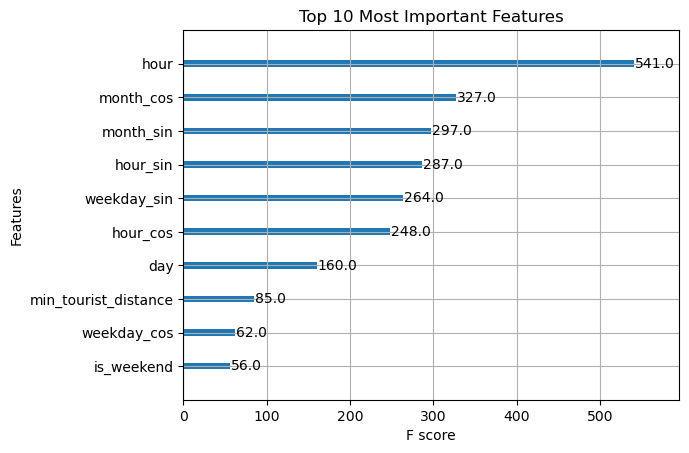

In [133]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Most Important Features")
plt.show()

In [134]:
class XGBRegressorCompat(XGBRegressor, BaseEstimator, RegressorMixin):
    def __sklearn_tags__(self):
        return {"non_deterministic": True}

features = [
    col for col in data.columns
    if col not in ["log_bike_count", "bike_count", "counter_id", "coordinates"]
]
X = data[features]
y = data["log_bike_count"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

param_distributions = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressorCompat(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random combinations to test
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_

y_train_pred = best_xgb_model.predict(X_train)
y_valid_pred = best_xgb_model.predict(X_valid)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best RMSE (CV): {random_search.best_score_:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {valid_rmse:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best RMSE (CV): -0.37
Train RMSE: 0.32
Validation RMSE: 0.36


In [135]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

def preprocess_for_xgboost(X):
    X = X.copy()
    
    # Convert categorical columns to codes
    categorical_cols = X.select_dtypes(include=["category", "object"]).columns
    for col in categorical_cols:
        X[col] = X[col].astype("category").cat.codes

    # Ensure all data types are valid
    return X

# Define the parameter grid (explores all combinations)
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

# Initialize the XGBoost model
xgb_model = XGBRegressorCompat(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE as scoring metric
    cv=3,                                  # 3-fold cross-validation
    verbose=1,                             # Debug output
    n_jobs=-1                              # Use all available CPUs
)

preprocessor = Pipeline(steps=[
    ("preprocess_for_xgboost", FunctionTransformer(preprocess_for_xgboost, validate=False))
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

# Fit the model using Grid Search
grid_search.fit(X_train_preprocessed, y_train)

# Best model and parameters
best_xgb_model = grid_search.best_estimator_

# Evaluate the model
y_train_pred = best_xgb_model.predict(X_train)
y_valid_pred = best_xgb_model.predict(X_valid)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

# Print results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best RMSE (CV): {grid_search.best_score_:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {valid_rmse:.2f}")'''

'from sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\ndef preprocess_for_xgboost(X):\n    X = X.copy()\n    \n    # Convert categorical columns to codes\n    categorical_cols = X.select_dtypes(include=["category", "object"]).columns\n    for col in categorical_cols:\n        X[col] = X[col].astype("category").cat.codes\n\n    # Ensure all data types are valid\n    return X\n\n# Define the parameter grid (explores all combinations)\nparam_grid = {\n    \'n_estimators\': [100, 150, 200],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'max_depth\': [3, 5, 7],\n    \'subsample\': [0.6, 0.8],\n    \'colsample_bytree\': [0.6, 0.8]\n}\n\n# Initialize the XGBoost model\nxgb_model = XGBRegressorCompat(random_state=42)\n\n# Perform Grid Search\ngrid_search = GridSearchCV(\n    estimator=xgb_model,\n    param_grid=param_grid,\n    scoring=\'neg_root_mean_squared_error\',  # RMSE as scoring metric\n    cv=3,                      

In [136]:
test_data = pd.read_parquet(Path("data") / "final_test.parquet")
test_data = _encode_dates(test_data)

# Preprocess the test data
test_data_preprocessed = preprocessor.transform(test_data)

# Make predictions on the test data using the optimized model
test_predictions = best_xgb_model.predict(test_data_preprocessed)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    "Id": range(len(test_predictions)),  # Assuming sequential indices for Id
    "log_bike_count": test_predictions
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv


In [137]:
import os
downloads_path = os.path.expanduser("~/Downloads")
submission_df.to_csv(os.path.join(downloads_path, "submission.csv"), index=False)

In [138]:
import pandas as pd

# Load the datasets
train_df = pd.read_parquet("data/train.parquet")
weather_data = pd.read_csv("data/external_data.csv")

# Convert 'date' columns to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Merge the datasets on 'date'
merged_data = pd.merge(train_df, weather_data, on='date', how='left')

# Check for duplicates in the 'date' column after merging
if merged_data.duplicated(subset='date').any():
    print("Warning: Duplicate rows found after merging!")

# Remove columns with more than 70% missing values
threshold = 0.7 * len(merged_data)
merged_data = merged_data.loc[:, merged_data.isnull().sum() <= threshold]

# Fill missing values with median for numeric columns
merged_data = merged_data.fillna(merged_data.median(numeric_only=True))

# Optionally handle categorical columns if present (fill with mode)
categorical_columns = merged_data.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

# Check the columns and basic statistics
print("Merged data columns:", merged_data.columns)
print("Basic statistics after preprocessing:")
print(merged_data.describe(include="all"))

'''# Save the cleaned merged dataset for later use
merged_data.to_csv("data/merged_data.csv", index=False)
print("Merged data saved to 'data/merged_data.csv'")'''

Merged data columns: Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count',
       'numer_sta', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u',
       'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'pres', 'tend24', 'raf10',
       'rafper', 'per', 'etat_sol', 'ht_neige', 'rr1', 'rr3', 'rr6', 'rr12',
       'rr24'],
      dtype='object')
Basic statistics after preprocessing:


/var/folders/jc/16b4bhxs5pb1zk_fkwc7lk280000gn/T/ipykernel_70400/400893788.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)


                 counter_id                                  counter_name  \
count                496881                                        496881   
unique                   56                                            56   
top     100007049-101007049  Face au 4 avenue de la porte de Bagnolet O-E   
freq                   8975                                          8975   
mean                    NaN                                           NaN   
min                     NaN                                           NaN   
25%                     NaN                                           NaN   
50%                     NaN                                           NaN   
75%                     NaN                                           NaN   
max                     NaN                                           NaN   
std                     NaN                                           NaN   

             site_id               site_name     bike_count  \
count   4.96

'# Save the cleaned merged dataset for later use\nmerged_data.to_csv("data/merged_data.csv", index=False)\nprint("Merged data saved to \'data/merged_data.csv\'")'

In [139]:
merged_data.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count',
       'numer_sta', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u',
       'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'pres', 'tend24', 'raf10',
       'rafper', 'per', 'etat_sol', 'ht_neige', 'rr1', 'rr3', 'rr6', 'rr12',
       'rr24'],
      dtype='object')

In [181]:
def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    return X

In [ ]:
data = _encode_dates(data)

In [179]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import holidays

# Tourist locations in Paris
tourist_locations = {
    "Eiffel Tower": (48.8584, 2.2945),
    "Louvre Museum": (48.8606, 2.3376),
    "Notre Dame Cathedral": (48.852968, 2.349902),
    "Sacré-Cœur": (48.8867, 2.3431),
    "Arc de Triomphe": (48.8738, 2.2950),
}

# Haversine formula to calculate distance
def _haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Add minimum tourist distance feature
def _add_tourist_proximity(X):
    X = X.copy()
    distances = []

    for location, (lat_tourist, lon_tourist) in tourist_locations.items():
        distance = _haversine(X["latitude"], X["longitude"], lat_tourist, lon_tourist)
        distances.append(distance)

    X["min_tourist_distance"] = np.min(distances, axis=0)
    return X

# Encode weather conditions
'''def _encode_weather_conditions(X):
    X = X.copy()
    
    # Check if required columns are present
    if "rr1" not in X.columns or "t" not in X.columns:
        X["weather_condition"] = "unknown"  # Assign a default category
    else:
        X["weather_condition"] = np.where(
            (X["rr1"] <= 1) & (X["t"] >= 15) & (X["t"] <= 25),
            "good",
            "bad",
        )

    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded_features = encoder.fit_transform(X[["weather_condition"]])
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=encoder.get_feature_names_out(["weather_condition"]),
        index=X.index
    )
    X = X.drop(columns=["weather_condition"], errors="ignore")
    X = pd.concat([X, encoded_df], axis=1)
    return X'''

# Define the preprocessing pipeline

    # Apply cyclical encoding
    X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)
    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)
    X["weekday_sin"] = np.sin(2 * np.pi * X["weekday"] / 7)
    X["weekday_cos"] = np.cos(2 * np.pi * X["weekday"] / 7)

    return X

def _drop_low_value_features(X):
    X = X.copy()
    X.drop(columns=['date', 'year', 'month', 'day', 'site_id', 'counter_id', 
                    'counter_installation_date', 'counter_technical_id', 
                    'coordinates', 'latitude', 'longitude'], inplace=True, errors="ignore")
    return X

preprocessor = Pipeline(steps=[
    ("add_rush_hour", FunctionTransformer(_add_rush_hour_indicator, validate=False)),
    ("add_weekend", FunctionTransformer(_add_weekend_indicator, validate=False)),
    ("add_holiday", FunctionTransformer(_add_holiday_indicator, validate=False)),
    ("encode_categorical", FunctionTransformer(_encode_categorical_features, validate=False)),
    ("encode_dates", FunctionTransformer(_encode_dates, validate=False)),
    ("add_tourist_proximity", FunctionTransformer(_add_tourist_proximity, validate=False)),
    ("drop_low_value_features", FunctionTransformer(_drop_low_value_features, validate=False)),
])

# Load and preprocess data
data = pd.read_parquet("data/train.parquet")
weather_data = pd.read_csv("data/external_data.csv")
data["date"] = pd.to_datetime(data["date"])
weather_data["date"] = pd.to_datetime(weather_data["date"])

weather_data = weather_data[["date", "ff", "t", "vv", "ww", "n", "etat_sol", "ht_neige", "rr1"]]

# Merge datasets
merged_data = pd.merge(data, weather_data, on="date", how="left")

# Apply preprocessing
processed_data = preprocessor.fit_transform(merged_data)

# Prepare features and target
features = [
    col for col in processed_data.columns if col not in ["log_bike_count", "bike_count"]
]
X = processed_data[features]
y = processed_data["log_bike_count"]

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter search space
param_distributions = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize and train the model
xgb_model = XGBRegressor(random_state=42, enable_categorical=True, tree_method="hist")
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

# Evaluate the best model
best_xgb_model = random_search.best_estimator_
y_train_pred = best_xgb_model.predict(X_train)
y_valid_pred = best_xgb_model.predict(X_valid)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best RMSE (CV): {random_search.best_score_:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {valid_rmse:.2f}")



KeyError: 'hour'

In [175]:
merged_data.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count', 'ff',
       't', 'vv', 'ww', 'n', 'etat_sol', 'ht_neige', 'rr1'],
      dtype='object')